# C. Grupo espacial y propiedades fisicas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json

In [ ]:
%matplotlib notebook

In [3]:
### SIMETRÍAS

def Id(r):
    E=np.eye(3)
    return np.matmul(E,r)

def Cn(r,n,axis):
    '''
    Rotación
    
    r: Array de 3 coordenadas a rotar
    axis: Array de 3 coordenadas que en dirección del eje de rotación. El programa lo transforma en un vector unitario
    automáticamente.
    n: Da un ángulo de rotación theta=2pi/n
    '''
    axis = axis/np.sqrt(sum(axis*axis))  #Normaliza
    ux,uy,uz = axis      #Obtiene las componentes
    sin,cos = (np.around(np.sin(2*np.pi/n),4),np.around(np.cos(2*np.pi/n),4))     #Para simplificar matriz (y redondea los numeros sueltos a 4 decimales)
    
    R=np.array([[cos+np.power(ux,2)*(1-cos), ux*uy*(1-cos)-uz*sin, ux*uz*(1-cos)+uy*sin],
                [uy*ux*(1-cos)+uz*sin, cos+np.power(uy,2)*(1-cos), uy*uz*(1-cos)-ux*sin],
                [uz*ux*(1-cos)-uy*sin, uz*uy*(1-cos)+ux*sin, cos+np.power(uz,2)*(1-cos)]])
    return np.matmul(R,r)
    
def S(r,axis):
    '''
    Reflexión con respecto a un plano con vector normal dado por axis
    
    r: Array de 3 coordenadas 
    axis: Array de 3 coordenadas normal al plano de reflexión. El programa lo transforma en un vector unitario
    automáticamente.
    '''
    axis = axis/np.sqrt(sum(axis*axis))  #Normaliza
    ux,uy,uz = axis      #Obtiene las componentes
    
    R=np.array([[1-2*np.power(ux,2), -2*ux*uy, -2*ux*uz],
               [-2*ux*uy, 1-2*np.power(uy,2), -2*uy*uz],
               [-2*ux*uz, -2*uy*uz, 1-2*np.power(uz,2)]])
    return np.matmul(R,r)

def i(r):
    """
    Inversión con respecto al origen
    
    r: Array de 3 coordenadas 
    """
    return -r

### GENERADORES DE EJES DE SIMETRÍA

def Ejes (A, B, C, AB, BC, AC):
    '''
    Genera un Array de tres vectores X, Y, Z con módulo A, B, C y 
    ángulos entre ellos AB, BC, AC (en radianes).
    Fija la libertad de variables tomando X=(A1,0,0) y Y=(B1,B2,0)
    (Las expresiones salen de resolver las ecuaciones de producto punto entre los 3 vectores)
    '''
    p, q, r = np.around(A*B*np.cos(AB),4), np.around(B*C*np.cos(BC),4), np.around(A*C*np.cos(AC),4)
    X = np.array([A,0,0])
    Y = np.array([p/A, np.sqrt(B**2-p**2/A**2),0])
    Z = np.array([r/A, (q-p*r/A**2)/Y[1], np.sqrt(C**2-((q-p*r/A**2)/Y[1])**2-(r/A)**2)])
    return np.array([X,Y,Z])

def EjesBrutos(N):
    '''
    Genera un array de muchos ejes unitarios que barren media esfera con parámetro de finura N>>1
    '''
    EjesBrutos=[[0,0,1]]
    for i in np.arange(1, N/4+2):
        EjesBrutos.append(Cn(np.array([0,0,1]),N/i,np.array([0,1,0])))
    e = EjesBrutos[:]
    for r in e:
        for i in np.arange(1,N+1):
            EjesBrutos.append(Cn(r,N/i,np.array([0,0,1])))
    return np.array(EjesBrutos)

In [38]:
class Molecula (object):
    """
    Clase que representa a la posición y tipo de átomos en una molécula 
    coordenadas y una lista de elementos
    """
    # Las clases tienen instancias y métodos.
    # El primer método que se necesita es un inicializador
    def __init__(self, coords, elements, coords_relative=True):
        """
        Crear una base atómica a partir de una lista de coordenadas y de átomos 
        Se asume por ausencia que las posiciones están dadas en coordenadas relativas
        
        Argumentos:
          coords -> arreglo de coordenadas (vectores)
          elements -> lista de elementos
          coords_relative -> BOOL (True por descarte)
        """
        coor = np.array(coords, dtype=np.float64)
        
        nats = np.shape(coor)[0]
        if ( len(elements) != nats):
            print ('Error: número de elementos y número de átomos (coordenadas) debe ser el mismo')
                   
        self.coords = coor
        self.elements = elements
        self.nats = nats
        self.relative = coords_relative
    
    @property
    def son_relativas(self):
        return self.relative
    
    @property
    def get_number_of_atoms(self):
        return self.nats
    
    def igual_a(self,M):
        '''
        Compara si la molécula es igual a la molécula M
        '''
        numiguales = 0
        for i in range(0, self.nats):
            for j in range(0, M.nats):
                d = self.coords[i]-M.coords[j]
                dist = np.sqrt(sum(d*d))
                if dist < 0.3 and self.elements[i] == M.elements[j]: #Por errores numéricos puede que no queden exactamente igual
                    numiguales+=1   #Los atomos en el mismo lugar y del mismo elemento
                    
        if numiguales == self.nats:
            return True
        else:
            return False
    
    def IdM(self): 
        """
        Crea otra molécula con Id aplicada
        """
        Idcoord = []
        E=np.eye(3)
        for r in self.coords:
            Idcoord.append(np.matmul(E,r))
        return Molecula(Idcoord, self.elements)
    
    def iM(self): 
        """
        Crea otra molécula con i aplicada
        """
        Idcoord = []
        for r in self.coords:
            Idcoord.append(-r)
        return Molecula(Idcoord, self.elements)
        
    def CnM(self, n, axis):
        '''
        Crea otra molécula con Cn aplicada
        
        Axis: Array de 3 coordenadas que en dirección del eje de rotación. El programa lo transforma en un vector unitario
        automáticamente.
        n: Da un ángulo de rotación theta=2pi/n
        '''
        axis = axis/np.sqrt(sum(axis*axis))  #Normaliza
        ux,uy,uz = axis      #Obtiene las componentes
        sin,cos = (np.around(np.sin(2*np.pi/n),4),np.around(np.cos(2*np.pi/n),4))     #Para simplificar matriz (y redondea los numeros sueltos a 4 decimales)
        
        R=np.array([[cos+np.power(ux,2)*(1-cos), ux*uy*(1-cos)-uz*sin, ux*uz*(1-cos)+uy*sin],
                    [uy*ux*(1-cos)+uz*sin, cos+np.power(uy,2)*(1-cos), uy*uz*(1-cos)-ux*sin],
                    [uz*ux*(1-cos)-uy*sin, uz*uy*(1-cos)+ux*sin, cos+np.power(uz,2)*(1-cos)]])
        
        Cncoord = []
        for r in self.coords:
            Cncoord.append(np.matmul(R,r))
        return Molecula(Cncoord, self.elements)
    
    def SM(self, axis):
        '''
        Crea otra molécula con S aplicada
        
        Axis: Array de 3 coordenadas normal al plano de reflexión. El programa lo transforma en un vector unitario
        automáticamente.
        '''
        axis = axis/np.sqrt(sum(axis*axis))  #Normaliza
        ux,uy,uz = axis      #Obtiene las componentes
        
        R=np.array([[1-2*np.power(ux,2), -2*ux*uy, -2*ux*uz],
                   [-2*ux*uy, 1-2*np.power(uy,2), -2*uy*uz],
                   [-2*ux*uz, -2*uy*uz, 1-2*np.power(uz,2)]])
        
        Scoord = []
        for r in self.coords:
            Scoord.append(np.matmul(R,r))
        return Molecula(Scoord, self.elements)
    
    def SnM(self, n, axis):
        '''
        Crea otra molécula con Sn aplicada (rotación impropia, rotación seguida de reflexión por el plano)
        
        Axis: Array de 3 coordenadas que en dirección del eje de rotación. El programa lo transforma en un vector unitario
        automáticamente.
        n: Da un ángulo de rotación theta=2pi/n
        '''
        M = self.CnM(n, axis)
        return M.SM(axis)
        
    
    def Simetria_Id(self):
        """
        Verifica si la molécula es invariante bajo la identidad
        """
        return self.igual_a(self.IdM())
    
    def Simetria_i(self):
        """
        Verifica si la molécula es invariante bajo la inversión con respecto al centro
        """
        return self.igual_a(self.iM())
    
    
    def Simetria_Cn(self, n, axis):
        """
        Verifica si la molécula es invariante bajo Cn
        """
        return self.igual_a(self.CnM(n, axis))
    
    def Simetria_S(self, axis):
        """
        Verifica si la molécula es invariante bajo S
        """
        return self.igual_a(self.SM(axis))
    
    def Simetria_Sn(self, n, axis):
        """
        Verifica si la molécula es invariante bajo Sn
        """
        return self.igual_a(self.SnM(n, axis))
    
    def Axis(self):
        '''
        Busca todos los posibles ejes de simetría
        '''
        E = 0.08 #Epsilon de distancia cero con error numerico
        RawAxis = EjesBrutos(60) #Array de muchos vectores unitarios que barren la esfera
        axis_list=[]
        
        for axis in RawAxis:
            for n in range(2,7): #No puede ser muy grande, para evitar errores numéricos y aumentar rapidez
                if self.Simetria_Cn(n,axis) or self.Simetria_S(axis) or self.Simetria_Sn(n,axis):
                    axis_list.append(axis.tolist()) #Ahorita trabajamos con listas para poder usar .remove()
                    break #Ya no necesitamos probar con otro orden de simetrías
        
        #Promediamos todos los que son parecidos, que se pueden repetir
        final_axis_list=[]
        for axis in np.array(axis_list):
            Repetido = False
            for A in final_axis_list:
                if np.sqrt(sum((axis-A)**2)) < E  or np.sqrt(sum((axis+ax)**2)) < E: #Colineal o antípodo
                    Repetido = True
            if Repetido == False: #No se ha hecho ese promedio de ese grupo de vectores parecidos
                parecidos=[]
                for ax in np.array(axis_list):
                    if np.sqrt(sum((axis-ax)**2)) < E: #Colineal
                        axis_list.remove(ax.tolist())
                        parecidos.append(ax)
                    if np.sqrt(sum((axis+ax)**2)) < E: #Antipodo
                        axis_list.remove(ax.tolist())
                        parecidos.append(-ax) #El menos es para invertir la dirección del antípodo
                if len(parecidos) != 0:
                    final_axis_list.append(sum(parecidos)/len(parecidos)) #Promediamos todos los que son parecidos
                    #final_axis_list.append(sum(parecidos)/np.sqrt(sum(sum(parecidos)*sum(parecidos)))) #Promediamos todos los que son parecidos
        return np.array(final_axis_list)
    
    def Grupo_puntual(self):
        """
        Busca el grupo puntual
        axis_list es un array de los posibles ejes de simetría no colineales (incluyendo ejes normales a planos de simetría),
        tomando como eje principal el primer elemento de la lista
        Regresa un string con el nombre del grupo
        """
        #Ejes de simetría:
        axis_list = self.Axis()
        print ('Los ejes de simetría no colineales son: '+str(axis_list))
        
        #Encontrando el eje principal de simetría (El que tiene simetría Cn con n más grande)
        N=0
        axis = axis_list[0]
        for ax in axis_list:
            for n in range(13,2,-1):
                if self.Simetria_Cn(n,ax) or self.Simetria_Sn(n,ax):
                    if n>N:
                        axis = ax #Eje principal de simetría
                        N=n
                    break
        print ('El eje principal de simetria es: '+str(axis))
        
        #Encontrando el grupo puntual
        print('El grupo puntual es: ')
        
        if self.Simetria_Cn(10, axis) and self.Simetria_Cn(20, axis) and self.Simetria_Cn(30, axis) and self.Simetria_Cn(40, axis) and self.Simetria_Cn(50, axis):
            #Se checó por simetría de rotación infinita sin que las rotaciones sean muy pequeñas para ser indetectables numéricamente
            if self.Simetria_i():
                return 'D_{inf h}'
            else:
                return 'C_{inf v}'
        else:
            #Checando si tiene 2 o mas ejes de simetría C3
            n=0
            for a in axis_list:
                if self.Simetria_Cn(3, a):
                    n+=1
            if n>=2:
                #Checando si tiene 2 o mas ejes de simetría C5
                n=0
                for a in axis_list:
                    if self.Simetria_Cn(5, a):
                        n+=1
                if n>=2:
                    if self.Simetria_i():
                        return 'I_{h}'
                    else:
                        return 'I'
                else:
                    #Checando si tiene 2 o mas ejes de simetría C4
                    n=0
                    for a in axis_list:
                        if self.Simetria_Cn(4, a):
                            n+=1
                    if n>=2:
                        if self.Simetria_i():
                            return 'O_{h}'
                        else:
                            return 'O'
                    else:
                        #Checando si tiene 2 o mas planos de inversión
                        n=0
                        for a in axis_list:
                            if self.Simetria_S(a):
                                n+=1
                        if n>=2:
                            if self.Simetria_i():
                                return 'T_{h}'
                            else:
                                return 'T_{d}'
                        else:
                            return 'T'
            else:
                #Buscando el orden más grande de simetría Cn, si es que hay alguno (debe ser en el eje principal)
                for n in range(12,2,-1):
                    if self.Simetria_Cn(n, axis):
                        #Checando si hay n simetrías C2 con ejes perpendiculares al principal
                        #Primero encontramos todos los ejes C2:
                        C2 = []
                        for b in axis_list:
                            if self.Simetria_Cn(2,b):
                                C2.append(b)      
                        i=0
                        for a in C2: #No importa que incluyamos al principal, pues nunca es ortogonal a sí mismo
                            if np.dot(axis, a)<=0.1: #Simétrico y ortogonal
                                i+=1
                        if i==n:
                            #Checando si hay plano de reflexión horizontal (eje principal)
                            if self.Simetria_S(axis):
                                return 'D_{'+str(n)+'h}'
                            else:
                                #Checando si hay n planos de reflexión dihedricos (vector bisecta a dos ejes C2)
                                #Buscamos todos los ejes de simetria que bisectan a cualesquiera 2 de C2 (dihédricos)
                                D = []
                                for d in axis_list:
                                    for c1 in C2:
                                        for c2 in C2:
                                            if (np.abs(sum((c1+c2)*d))-np.sqrt(sum((c1+c2)**2)*sum(d**2))) < 0.1: #Colineales si el producto punto son las normas (salvo signo)
                                                D.append(d)
                                j=0
                                for d in D: #sigma_d: Buscamos simetria de reflexión en todos los planos dihedricos
                                    if self.Simetria_S(a) and np.dot(axis, a)<=0.01: #Simétrico y ortogonal
                                        j+=1
                                if j==n:
                                    return 'D_{'+str(n)+'d}'
                                else:
                                    return 'D_{'+str(n)+'}'
                        elif self.Simetria_S(axis): #No hubo n simetrías C2, checando si hay plano de reflexión horizontal (eje principal)
                            return 'C_{'+str(n)+'h}'
                        else:
                            #Checando si hay n planos de reflexión verticales (ortogonales a eje principal)
                            j=0
                            for a in axis_list: #No importa que incluyamos al principal, pues nunca es ortogonal a sí mismo
                                if self.Simetria_S(a) and np.dot(axis, a)<=0.01: #Simétrico y ortogonal
                                    j+=1
                            if j==n:
                                return 'C_{'+str(n)+'v}'
                            else:
                                #Checando si tiene un eje impropio de rotación S_2n
                                for a in axis_list: #No importa que incluyamos al principal, pues nunca es ortogonal a sí mismo
                                    if self.Simetria_Sn(2*n, a) and np.dot(axis, a)<=0.01: #Simétrico y ortogonal
                                        return 'S_{2'+str(n)+'}'
                                    else:
                                        return 'C_{'+str(n)+'}'
    
                #Termina el for sin que haya simetría Cn hasta el 12 (si intentamos más grande, puede que sea muy pequeña y haya errores numéricos) 
                for a in axis_list: #Checando si hay algún plano de reflexión
                    if self.Simetria_S(a):
                        return 'C_{s}'
                #No hubo planos de reflexión, buscando si hay simetría de inversión por el origen
                if self.Simetria_i():
                    return 'C_{i}'
                else:
                    return 'C_{1}'
                            
    def dibuja_enlaces(self,ax, max_length=3.1):
        nats = self.nats
        coords = self.coords
        for iat in range(nats):
            for jat in range(iat,nats):
                dist = np.linalg.norm(coords[jat,:]-coords[iat,:])
                if (dist <= max_length):
                    Axes3D.plot3D(ax,[coords[iat,0],coords[jat,0]],
                                  [coords[iat,1],coords[jat,1]]
                                  ,[coords[iat,2],coords[jat,2]],'r')
        
         
    def plot(self, ax):
        nats = self.nats
        self.dibuja_enlaces(ax)
        tipos_elem = np.unique(np.array(self.elements))
        for t in tipos_elem: #Para graficar de diferente color cada elemento diferente
            rx = []
            ry = []
            rz = []
            for i in range(self.nats):
                if self.elements[i] == t:
                    rx.append(self.coords[i][0])
                    ry.append(self.coords[i][1])
                    rz.append(self.coords[i][2])
            ax.scatter(np.array(rx), np.array(ry), np.array(rz), s=60)

## 1. Verifica que el grupo puntual del diamante es $O_h$, mientras que el del grafito es $D_{6h}$

### La celda FCC tiene en efecto simetría $O_{h}$

In [5]:
L1=2*(np.array([[0.00 , 0.00 , 0.00],[0.00 , 0.50 , 0.50],[0.50 , 0.00 , 0.50],[0.50 , 0.50 , 0.00],[1.0,1.0,1.0],
[1.0,0,0],[0,1.0,0],[0,0,1.0],[1.0,1.0,0.0],[1.0,0.0,1.0],[0.0,1.0,1.0],[0.50,1.0,0.50],[1.0,0.50,0.50],
[0.50,0.50,1.0]])-[0.5,0.5,0.5])

<IPython.core.display.Javascript object>


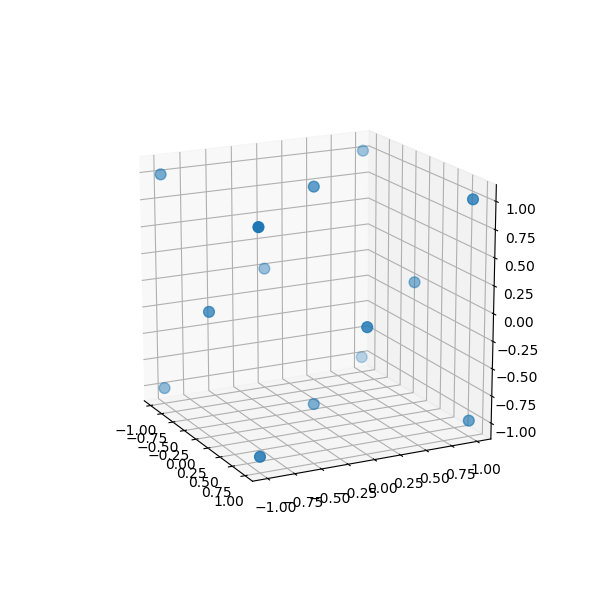

In [6]:
#Celda FCC
molec1 = Molecula (L1,len(L1)*['C'])
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal','datalim')
molec1.plot(ax)
plt.show()

In [7]:
molec1.Grupo_puntual()

Los ejes de simetría no colineales son: [[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 9.47723563e-02 -6.50521303e-19  9.94500000e-01]
 [ 2.03934307e-01 -4.33680869e-19  9.78100000e-01]
 ...
 [-9.78100000e-01  2.07900000e-01  0.00000000e+00]
 [-9.94500000e-01  1.04500000e-01  0.00000000e+00]
 [ 9.89030250e-01 -1.03925250e-01 -1.04500000e-01]]
El eje principal de simetria es: [0.6011679 0.5413019 0.5878   ]
El grupo puntual es: 


'O_{h}'

### La celda unitaria convencional del diamante está formada por dos celdas FCC interpenetradas:

In [8]:
L2=2*(np.array([[0.25 , 0.75 , 0.75],[0.00 , 0.00 , 0.00],[0.25 , 0.25 , 0.25],[0.00 , 0.50 , 0.50],
[0.75 , 0.75 , 0.25],[0.50 , 0.00 , 0.50],[0.75 , 0.25 , 0.75],[0.50 , 0.50 , 0.00],[1.0,1.0,1.0],
[1.0,0,0],[0,1.0,0],[0,0,1.0],[1.0,1.0,0.0],[1.0,0.0,1.0],[0.0,1.0,1.0],[0.50,1.0,0.50],[1.0,0.50,0.50],
[0.50,0.50,1.0]])-[0.5,0.5,0.5])

<IPython.core.display.Javascript object>


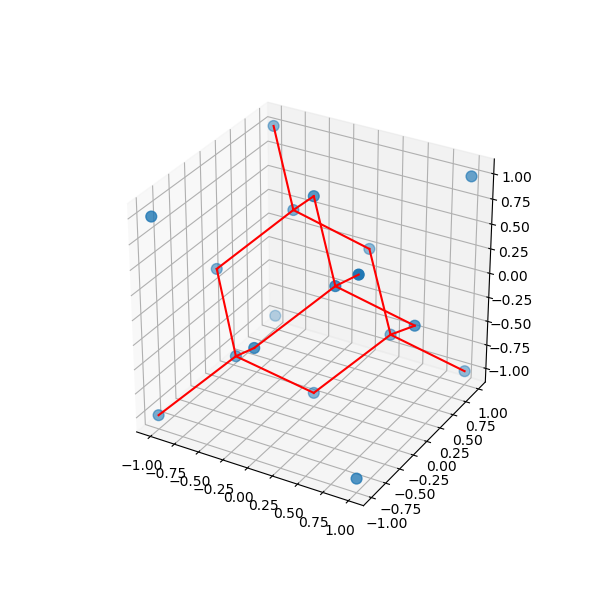

In [9]:
#Celda unitaria convencional del Diamante
molec2 = Molecula (L2,len(L2)*['C'])
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal','datalim')
molec2.plot(ax)
plt.show()

### Cuando tomamos la intepenetración de ambas celdas FCC se tiene una ruptura de la simetría, puesto que los ejes de cada celda no coinciden, de manera que la celda unitaria convencional NO tiene grupo de simetría O_{h}, sino un subgrupo de éste: T_{d}

(Ver Point Groups, Space Groups, Crystals, Molecules, por R. Mirman, p.162,
link al final)

In [10]:
molec2.Grupo_puntual()

Los ejes de simetría no colineales son: [[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 9.47723563e-02 -6.50521303e-19  9.94500000e-01]
 [ 6.67259975e-01  0.00000000e+00  7.43100000e-01]
 [ 7.43100000e-01  0.00000000e+00  6.69100000e-01]
 [ 9.94500000e-01  0.00000000e+00  1.04500000e-01]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.94500000e-01  0.00000000e+00 -1.04500000e-01]
 [ 3.63790625e-02  9.47723562e-02  9.94500000e-01]
 [-6.15478875e-02  7.60054625e-02  9.94500000e-01]
 [-9.64315550e-02 -2.58386700e-02  9.94500000e-01]
 [-2.05542000e-02 -9.67005000e-02  9.94500000e-01]
 [ 5.65240500e-02 -8.70380500e-02  9.94500000e-01]
 [ 3.49604750e-02  6.67259975e-01  7.43100000e-01]
 [-6.99209500e-02  6.65419950e-01  7.43100000e-01]
 [-6.67259975e-01  3.49604750e-02  7.43100000e-01]
 [-6.65419950e-01 -6.99209500e-02  7.43100000e-01]
 [-3.49604750e-02 -6.67259975e-01  7.43100000e-01]
 [ 6.99209500e-02 -6.65419950e-01  7.43100000e-01]
 [ 0.00000000e+00  7.43100000e-01  6.69100

'T_{d}'

### Grafito

In [35]:
L3 = 3*np.array([[1,0,0],[0.5,0.866,0.],[-0.499956,0.866,0.],[-9.99934e-01,3.81040e-05,0.],
              [-0.5, -0.86592379,0.],[0.49989,-0.86596189,0.]])

<IPython.core.display.Javascript object>


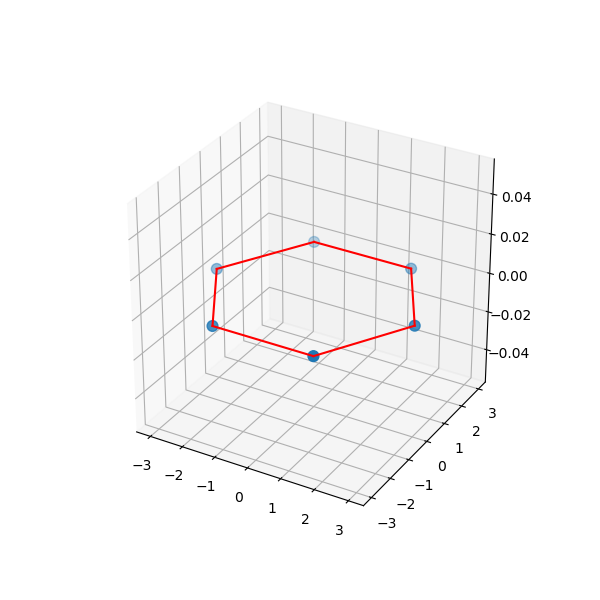

In [39]:
#Celda unitaria convencional del Grafito
molec3 = Molecula (L3,len(L3)*['C'])
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal','datalim')
molec3.plot(ax)
plt.show()

In [37]:
molec3.Grupo_puntual()

Los ejes de simetría no colineales son: [[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 9.47723563e-02 -6.50521303e-19  9.94500000e-01]
 [ 2.03934307e-01 -4.33680869e-19  9.78100000e-01]
 ...
 [-9.78100000e-01  2.07900000e-01  0.00000000e+00]
 [-9.94500000e-01  1.04500000e-01  0.00000000e+00]
 [ 9.89030250e-01 -1.03925250e-01 -1.04500000e-01]]
El eje principal de simetria es: [0. 0. 1.]
El grupo puntual es: 


'D_{6h}'

## 2. El grupo espacial del diamante es Fd-3m y el del grafito es P6/mmm. Utilizando la información en http://www.cryst.ehu.es/cgi-bin/cryst/programs/tensor.pl, compara el tensor de elasticidad ($C_{ijkl}$ que relaciona $σ_{ij} = C_{ijkl}\epsilon_{kl}$) y de conductividad eléctrica ($J_i = σ_{ij}E_j$ ) para las dos estructuras.

El tensor de conductividad eléctrica para Fd-3m:
$$\sigma_{ij} = 
\begin{bmatrix}
 \sigma_{11} & 0 & 0 \\
 0 & \sigma_{11} & 0 \\
 0 & 0 & \sigma_{11}
\end{bmatrix} $$
(1 componente independiente)

el de conductividad eléctrica para P6/mmm:
$$\sigma_{ij} = 
\begin{bmatrix}
 \sigma_{11} & 0 & 0 \\
 0 & \sigma_{11} & 0 \\
 0 & 0 & \sigma_{33}
\end{bmatrix} $$
(2 componentes independientes)

El sistema FCC es completamente isotrópico en todas las direcciones, de manera que el tensor de conductividad tiene que ser
diagonal y con la misma constante para cualquier dirección del sistema principal (x,y,z alineados con el cubo).
Por otra parte, el grafito tiene una ruptura de simetría en la dirección z, se tiene una anisotropía en esa dirección, lo cual se ve reflejado en su tensor de conductividad.

El tensor de elasticidad $C_{ijkl}$ (con notación abreviada $C_{ij}$) para Fd-3m:
$$C_{ij} = 
\begin{bmatrix}
 C_{11} & C_{12} & C_{12} & 0 & 0 & 0\\
 C_{12} & C_{11} & C_{12} & 0 & 0 & 0\\
 C_{12} & C_{12} & C_{11} & 0 & 0 & 0\\
 0 & 0 & 0 & C_{44} & 0 & 0\\
 0 & 0 & 0 & 0 & C_{44} & 0\\
 0 & 0 & 0 & 0 & 0 & C_{44}
\end{bmatrix} $$

(3 componentes independientes)

Donde se usó notación abreviada $C_{ijkl} \rightarrow C_{ij}$ con

$ij \rightarrow i$ si $i=j$

$ij \rightarrow 9-(i+j)$ si $i\neq j$

$kl \rightarrow j$ si $k=l$

$kl \rightarrow 9-(k+l)$ si $k\neq l$

el de elasticidad para P6/mmm:
$$C_{ij} = 
\begin{bmatrix}
 C_{11} & C_{12} & C_{13} & 0 & 0 & 0\\
 C_{12} & C_{11} & C_{13} & 0 & 0 & 0\\
 C_{13} & C_{13} & C_{33} & 0 & 0 & 0\\
 0 & 0 & 0 & C_{44} & 0 & 0\\
 0 & 0 & 0 & 0 & C_{44} & 0\\
 0 & 0 & 0 & 0 & 0 & \frac 12 (C_{11}-C_{12})
\end{bmatrix} $$

(5 componentes independientes)

Aquí también el $C_{ij}$ del sistema FCC corresponde a un sistema isotrópico, mientras que el del grafito también corresponde a un anisotrópico con una ruptura en la simetría en la dirección z.

(Ver Tensor de Elasticidad en referencias)

## Referencias:

Point Groups, Space Groups, Crystals, Molecules, por R. Mirman, p.162:
https://books.google.com.mx/books?id=fAolOGrjWZ0C&pg=PA162&lpg=PA162&dq=diamond+point+group&source=bl&ots=Za2eVMZOAV&sig=ACfU3U0P5gTcs6zZWvJ4A7u33iYMJYlMTw&hl=en&sa=X&ved=2ahUKEwjD_96CxObnAhUEr54KHRhTDa4Q6AEwEnoECA4QAQ#v=onepage&q=diamond%20point%20group&f=false

Tensor de elasticidad, sección "Anisotropic homogeneous media": 
https://en.wikipedia.org/wiki/Linear_elasticity